In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import re

## Load Data

In [12]:
with open('train/train.json') as f:
    train = json.load(f)
    train = pd.DataFrame(train)
with open('test1/test1.json') as f:
    test = json.load(f)
    test = pd.DataFrame(test)
train

,id,instruction,input,output,image
0,213e438b17282904772446704d0b28,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,商品材质,[213e438b17282904772446704d0b28-0.jpg]
1,2104a80d17282572952783243d0afd,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,商品材质,[2104a80d17282572952783243d0afd-0.jpg]
2,212c8bd517276234453407314d1039,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,商品规格,[212c8bd517276234453407314d1039-0.jpg]
3,2166278d17280312481914032d1034,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,排水方式,[2166278d17280312481914032d1034-0.jpg]
4,21082e0317274845152512370d0a96,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,控制方式,[21082e0317274845152512370d0a96-0.jpg]
...,...,...,...,...,...
995,d39621fd-6caf-42d8-9792-2273ec991a9e-325,"Picture 1: <image>\n你是一个电商领域识图专家,可以理解消费者上传的软件截...",,商品详情页截图,[d39621fd-6caf-42d8-9792-2273ec991a9e-325-0.jpg]
996,653c94a7-8e13-4e08-868e-91fb803e9232-627,"Picture 1: <image>\n你是一个电商领域识图专家,可以理解消费者上传的软件截...",,支付页面,[653c94a7-8e13-4e08-868e-91fb803e9232-627-0.jpg]
997,74106cd8-d76b-459c-84c2-63b90742cde0-1088,"Picture 1: <image>\n你是一个电商领域识图专家,可以理解消费者上传的软件截...",,物流页面-物流异常页面,[74106cd8-d76b-459c-84c2-63b90742cde0-1088-0.jpg]
998,91bea155-59a4-4926-b47c-a37e21f4b9f1-2326,"Picture 1: <image>\n你是一个电商领域识图专家,可以理解消费者上传的软件截...",,其他类别图片,[91bea155-59a4-4926-b47c-a37e21f4b9f1-2326-0.jpg]


In [13]:
# 根据 instruction 的前 20 个字符进行分组, 分为 image 和 text两类
train['task'] = train['instruction'].str[:20].apply(
    lambda x: 'image' if x == "Picture 1: <image>\n你" else 'text'
)
train['task'].value_counts()

task
image    700
text     300
Name: count, dtype: int64

In [14]:
def save_json(df, filepath):
    formatted_data = [
        {
            "id": row["id"],
            "instruction": row["instruction"],
            "input": row["input"],
            "output": row["output"],
            "image": row["image"] if isinstance(row["image"], list) else [row["image"]],
        }
        for _, row in df.iterrows()
    ]
    with open(filepath, "w", encoding="utf-8") as f:
        json.dump(formatted_data, f, ensure_ascii=False, indent=4)


In [15]:
from sklearn.model_selection import train_test_split
import pandas as pd

# 读取 train 数据，假设 train 是一个 DataFrame
train_image = train[train['task'] == 'image'].copy()
train_text = train[train['task'] == 'text'].copy()

save_json(train_text,"train/all_text.json")

# 对 train_image 数据集进行分层抽样
train_image, valid_image = train_test_split(
    train_image, test_size=0.2, random_state=42, stratify=train_image['output']
)
train_image.reset_index(drop=True, inplace=True)
valid_image.reset_index(drop=True, inplace=True)

# 保存分层抽样后的 train_image 和 valid_image
save_json(train_image, "train/train_image.json")
save_json(valid_image, "train/valid_image.json")

# 对 train_text 数据集进行分层抽样
train_text, valid_text = train_test_split(
    train_text, test_size=0.2, random_state=42, stratify=train_text['output']
)
train_text.reset_index(drop=True, inplace=True)
valid_text.reset_index(drop=True, inplace=True)

# 保存分层抽样后的 train_text 和 valid_text
save_json(train_text, "train/train_text.json")
save_json(valid_text, "train/valid_text.json")


## Data Exploration

### Length of two kinds of `instruction` 

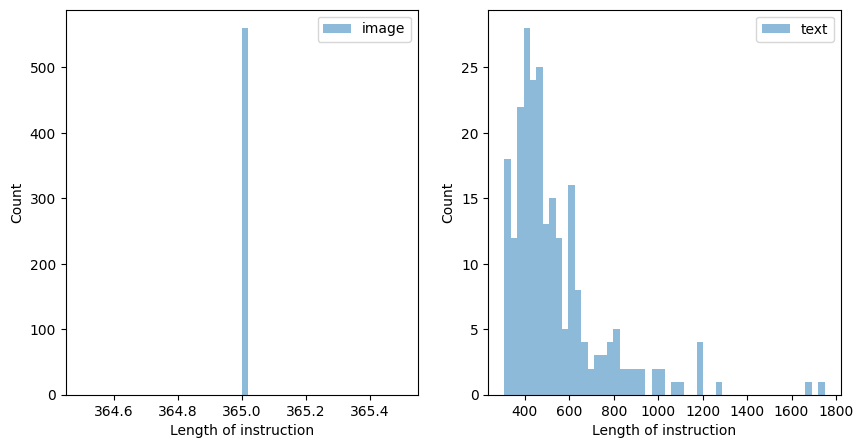

In [16]:
# 计算 image 和 text 类型的 instruction 的长度,并绘制两个子图
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.hist(train_image['instruction'].str.len(), bins=50, alpha=0.5, label='image')
plt.xlabel('Length of instruction')
plt.ylabel('Count')
plt.legend()
plt.subplot(1, 2, 2)
plt.hist(train_text['instruction'].str.len(), bins=50, alpha=0.5, label='text')
plt.xlabel('Length of instruction')
plt.ylabel('Count')
plt.legend()
plt.show()

In [17]:
# 将 instruction长度超过 1000 的instruction打印出来看看
train[train['instruction'].str.len() > 1000]

,id,instruction,input,output,image,task
5,2107347617277435206931576d0af4,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,是否易褪色,[2107347617277435206931576d0af4-0.jpg],text
49,213dbbe517278865952913592d0b10,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,是否好用,[213dbbe517278865952913592d0b10-0.jpg],text
111,212c5b2e17276183422897200d0b24,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,排水方式,[212c5b2e17276183422897200d0b24-0.jpg],text
179,212ccb5917282965269817932d13fb,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,排水方式,[212ccb5917282965269817932d13fb-0.jpg],text
213,0bf8fbfd17277183295445449d0ad8,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,用法用量,[0bf8fbfd17277183295445449d0ad8-0.jpg],text
239,0b52090217282960000927920d0b32,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,套装推荐,"[0b52090217282960000927920d0b32-0.jpg, 0b52090...",text
267,213ca3f617272237777542707d101d,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,排水方式,[213ca3f617272237777542707d101d-0.jpg],text
278,213ef6a617273607777854871d0b7c,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,套装推荐,[213ef6a617273607777854871d0b7c-0.jpg],text
282,213e5b6717280386556962296d1006,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,能否调光,"[213e5b6717280386556962296d1006-0.jpg, 213e5b6...",text
285,2107bb1017279214296645020d0f68,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,养护方法,[2107bb1017279214296645020d0f68-0.jpg],text


In [18]:
def extract_messages(instruction):
    # Regular expressions to extract user and customer messages
    user_pattern = r"用户: (.+)"
    customer_pattern = r"客服: (.+)"
    
    # Extracting the messages
    user_messages = re.findall(user_pattern, instruction)
    customer_messages = re.findall(customer_pattern, instruction)
    return user_messages, customer_messages

train_text['user_messages'], train_text['customer_messages'] = zip(*train_text['instruction'].apply(extract_messages))
train_text

,id,instruction,input,output,image,task,user_messages,customer_messages
0,2150ac5517273424710348239d1048,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,能否调光,[2150ac5517273424710348239d1048-0.jpg],text,"[<http>, 于未, <image>, 最初购买的那是哪一款, 九级，调节亮度，应该是九...","[来了来了，欢迎来到光明灯具~ 请问您买台灯是给自己用还是给家里的小朋友用？, 您好，您的订..."
1,2104be7517278113196275458d0fb1,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,养护方法,[2104be7517278113196275458d0fb1-0.jpg],text,"[<image>, 这些室内植物可以吗？]","[您好，这是您的商品列表截图，如果您有任何疑问，欢迎向我咨询。, 翠绿佳人具有较强的耐阴性，..."
2,21077f1817272305779762234d0af7,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,何时上货,[21077f1817272305779762234d0af7-0.jpg],text,"[<image>, 十月份的杂志已经上线了吗？]",[智能助手还在学习中，暂时无法识别图片内容，关于商品的问题可以通过发送链接告知，其他疑问请回...
3,2133f8be17279627305965388d1020,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,单品推荐,[2133f8be17279627305965388d1020-0.jpg],text,"[你好, <image>, 这个商品的网址是哪个？]","[您好！这款商品您有什么想问的吗？, 很抱歉，我们店铺暂时没有这款商品，您可以看看我们店里的..."
4,21547e6f17275698208415653d0b0f,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,是否会生锈,[21547e6f17275698208415653d0b0f-0.jpg],text,"[<image>, 这口锅是不是生锈了？]",[亲爱的，这款经过极致处理，拥有10小时续航，360°全面防护，不会生锈呢。]
...,...,...,...,...,...,...,...,...
235,0bf8ecdd17278417984286655d0fbf,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,商品材质,[0bf8ecdd17278417984286655d0fbf-0.jpg],text,"[<image>, 里面和这个相似吗？, 这看起来像是皮革制成的。]",[亲爱的，由于光线和角度的不同，拍摄出来的效果可能会有些许差异，我们的图片都是实物拍摄的，颜...
236,213e97a017276141281136851d0fe5,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,包装区别,[213e97a017276141281136851d0fe5-0.jpg],text,"[您好, 想问一下，5公斤的量就只有这种包装方式吗？, <image>, 想确认一下这个是不...",[在的，我是智能助手小星，有什么能为您服务的吗？在节假日我们由系统自动回复，若您有任何售后问...
237,0b51dfbb17277070734367651d0ae1,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,商品材质,[0b51dfbb17277070734367651d0ae1-0.png],text,"[<http>, <image>, 鞋的表面是编织网状的，还是布质或皮革的？]","[您好，有什么需要我协助的吗？, 亲爱的，您的消息已经收到，有什么可以帮忙的吗？, 亲爱的，..."
238,213624b217275032277666813d0f9e,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,反馈密封性不好,[213624b217275032277666813d0f9e-0.jpg],text,"[<image>, 这个问题是漏气引起的。, 我已经尝试了三次了。]",[亲爱的，您如果有任何疑问，可以文字告诉我哦~ 如果问题没有得到解决，请回复【转人工服务】，...


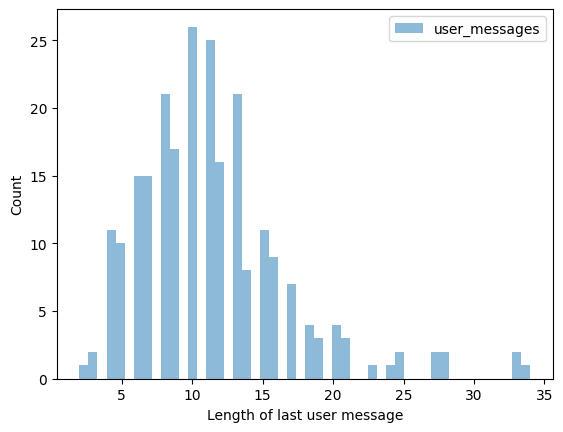

In [19]:
# 统计 user_messages的最后一个元素的长度，并绘制直方图
plt.hist([len(x[-1]) for x in train_text['user_messages']], bins=50, alpha=0.5, label='user_messages')
plt.xlabel('Length of last user message')
plt.ylabel('Count')
plt.legend()
plt.show()

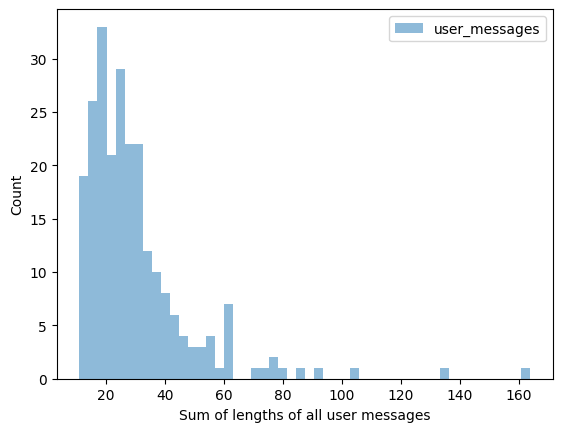

In [20]:
# 统计 user_messages的所有元素的长度和，并绘制直方图
plt.hist([sum(len(x) for x in y) for y in train_text['user_messages']], bins=50, alpha=0.5, label='user_messages')
plt.xlabel('Sum of lengths of all user messages')
plt.ylabel('Count')
plt.legend()
plt.show()

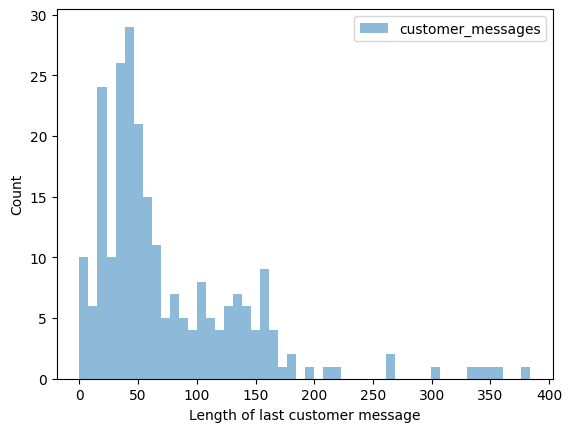

In [21]:
# 统计 customer_messages的最后一个元素的长度，并绘制直方图
plt.hist([len(x[-1]) if len(x)>0 else 0 for x in train_text['customer_messages']], bins=50, alpha=0.5, label='customer_messages')
plt.xlabel('Length of last customer message')
plt.ylabel('Count')
plt.legend()
plt.show()

## labels distribution

In [22]:
train_text['output'].value_counts()

output
适用季节       19
单品推荐       16
包装区别       14
套装推荐       14
用法用量       14
版本款型区别     14
功效功能       14
反馈密封性不好    12
能否调光       11
商品材质       11
发货数量       11
商品规格       11
控制方式       10
气泡         10
何时上货       10
上市时间        9
养护方法        8
信号情况        7
排水方式        7
是否会生锈       6
是否好用        6
是否易褪色       3
反馈用后症状      3
Name: count, dtype: int64

In [23]:
train_image['output'].value_counts()

output
商品分类选项                 31
商品详情页截图                30
优惠券领取页面                30
购物车页面                  30
活动页面                   30
商品头图                   30
支付页面                   30
退货页面                   30
账单/账户页面                29
退款页面                   29
其他类别图片                 28
投诉举报页面                 25
外部APP截图                25
店铺页面                   24
下单过程中出现异常（显示购买失败浮窗）    22
评论区截图页面                22
物流页面-物流跟踪页面            21
物流页面-物流异常页面            20
换货页面                   18
实物拍摄(含售后)              18
平台介入页面                 14
订单详情页面                 12
物流页面-物流列表页面            12
Name: count, dtype: int64

In [24]:
train_image

,id,instruction,input,output,image,task
0,a7503780-b869-4cb0-bc4b-e8b1ef00c140-6,"Picture 1: <image>\n你是一个电商领域识图专家,可以理解消费者上传的软件截...",,实物拍摄(含售后),[a7503780-b869-4cb0-bc4b-e8b1ef00c140-6-0.jpg],image
1,b496e0f4-6b26-4a6c-b8a5-a3ed09b33276-2276,"Picture 1: <image>\n你是一个电商领域识图专家,可以理解消费者上传的软件截...",,其他类别图片,[b496e0f4-6b26-4a6c-b8a5-a3ed09b33276-2276-0.jpg],image
2,f1847dcd-1afd-46e8-b0fa-ddd948ff577a-358,"Picture 1: <image>\n你是一个电商领域识图专家,可以理解消费者上传的软件截...",,商品详情页截图,[f1847dcd-1afd-46e8-b0fa-ddd948ff577a-358-0.jpg],image
3,7ecdc46f-b992-467c-a41e-3ad966ec2286-303,"Picture 1: <image>\n你是一个电商领域识图专家,可以理解消费者上传的软件截...",,商品详情页截图,[7ecdc46f-b992-467c-a41e-3ad966ec2286-303-0.jpg],image
4,e52bdf0e-cc38-4a9b-9777-6e3a3fda5aaa-2125,"Picture 1: <image>\n你是一个电商领域识图专家,可以理解消费者上传的软件截...",,平台介入页面,[e52bdf0e-cc38-4a9b-9777-6e3a3fda5aaa-2125-0.jpg],image
...,...,...,...,...,...,...
555,e3538419-50bf-4419-91df-6aba7e7c561f-20,"Picture 1: <image>\n你是一个电商领域识图专家,可以理解消费者上传的软件截...",,实物拍摄(含售后),[e3538419-50bf-4419-91df-6aba7e7c561f-20-0.jpg],image
556,18e19810-8472-4b55-917a-4f0a9eaab3cc-53,"Picture 1: <image>\n你是一个电商领域识图专家,可以理解消费者上传的软件截...",,实物拍摄(含售后),[18e19810-8472-4b55-917a-4f0a9eaab3cc-53-0.jpg],image
557,578387b6-41e9-4557-9bd9-1129fc48717a-2356,"Picture 1: <image>\n你是一个电商领域识图专家,可以理解消费者上传的软件截...",,其他类别图片,[578387b6-41e9-4557-9bd9-1129fc48717a-2356-0.jpg],image
558,c5aaa403-e3aa-4441-8ea7-20bd48c5bbc7-381,"Picture 1: <image>\n你是一个电商领域识图专家,可以理解消费者上传的软件截...",,商品详情页截图,[c5aaa403-e3aa-4441-8ea7-20bd48c5bbc7-381-0.jpg],image


## 不同 input 设计需要的长度

In [25]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("./Qwen2.5-1.5B")

In [26]:
def design_input_text(user_messages, customer_messages, save='user+'):
    input_text = ''
    if save == 'user+':
        input_text = '用户: ' + ' '.join(user_messages)
    elif save == 'user+customer-':
        if len(customer_messages) > 0:
            input_text = '用户: ' + ' '.join(user_messages) + ' ' + '客服: ' + customer_messages[-1]
        else:
            input_text = '用户: ' + ' '.join(user_messages) + ' ' + '客服: ' + '无'
    elif save == 'user-':
        input_text = '用户: ' + user_messages[-1]
    elif save == 'user-customer-':
        if len(customer_messages) > 0:
            input_text = '用户: ' + user_messages[-1] + ' ' + '客服: ' + customer_messages[-1]
        else:
            input_text = '用户: ' + user_messages[-1] + ' ' + '客服: ' + '无'

    return input_text

In [27]:
for mode in ['user+', 'user+customer-', 'user-', 'user-customer-']:
    train_text[mode] = train_text.apply(lambda row: design_input_text(row['user_messages'], row['customer_messages'], save=mode), axis=1)
    train_text[mode+'_ids'] = train_text[mode].apply(lambda x: tokenizer.encode(x))
train_text

,id,instruction,input,output,image,task,user_messages,customer_messages,user+,user+_ids,user+customer-,user+customer-_ids,user-,user-_ids,user-customer-,user-customer-_ids
0,2150ac5517273424710348239d1048,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,能否调光,[2150ac5517273424710348239d1048-0.jpg],text,"[<http>, 于未, <image>, 最初购买的那是哪一款, 九级，调节亮度，应该是九...","[来了来了，欢迎来到光明灯具~ 请问您买台灯是给自己用还是给家里的小朋友用？, 您好，您的订...",用户: <http> 于未 <image> 最初购买的那是哪一款 九级，调节亮度，应该是九个...,"[20002, 25, 366, 1254, 29, 220, 34204, 38342, ...",用户: <http> 于未 <image> 最初购买的那是哪一款 九级，调节亮度，应该是九个...,"[20002, 25, 366, 1254, 29, 220, 34204, 38342, ...",用户: 九级，调节亮度，应该是九个级别对吗,"[20002, 25, 220, 99609, 52334, 3837, 105053, 1...",用户: 九级，调节亮度，应该是九个级别对吗 客服: 您好，您指的是哪一款呢？请选择您感兴趣的...,"[20002, 25, 220, 99609, 52334, 3837, 105053, 1..."
1,2104be7517278113196275458d0fb1,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,养护方法,[2104be7517278113196275458d0fb1-0.jpg],text,"[<image>, 这些室内植物可以吗？]","[您好，这是您的商品列表截图，如果您有任何疑问，欢迎向我咨询。, 翠绿佳人具有较强的耐阴性，...",用户: <image> 这些室内植物可以吗？,"[20002, 25, 366, 1805, 29, 32181, 247, 97084, ...",用户: <image> 这些室内植物可以吗？ 客服: 翠绿佳人具有较强的耐阴性，日常养护时可...,"[20002, 25, 366, 1805, 29, 32181, 247, 97084, ...",用户: 这些室内植物可以吗？,"[20002, 25, 32181, 247, 97084, 104517, 104155,...",用户: 这些室内植物可以吗？ 客服: 翠绿佳人具有较强的耐阴性，日常养护时可将其置于散射光环...,"[20002, 25, 32181, 247, 97084, 104517, 104155,..."
2,21077f1817272305779762234d0af7,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,何时上货,[21077f1817272305779762234d0af7-0.jpg],text,"[<image>, 十月份的杂志已经上线了吗？]",[智能助手还在学习中，暂时无法识别图片内容，关于商品的问题可以通过发送链接告知，其他疑问请回...,用户: <image> 十月份的杂志已经上线了吗？,"[20002, 25, 366, 1805, 29, 66521, 223, 104081,...",用户: <image> 十月份的杂志已经上线了吗？ 客服: 尊敬的顾客，目前尚未收到相关通知...,"[20002, 25, 366, 1805, 29, 66521, 223, 104081,...",用户: 十月份的杂志已经上线了吗？,"[20002, 25, 66521, 223, 104081, 9370, 102542, ...",用户: 十月份的杂志已经上线了吗？ 客服: 尊敬的顾客，目前尚未收到相关通知，建议您持续关注...,"[20002, 25, 66521, 223, 104081, 9370, 102542, ..."
3,2133f8be17279627305965388d1020,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,单品推荐,[2133f8be17279627305965388d1020-0.jpg],text,"[你好, <image>, 这个商品的网址是哪个？]","[您好！这款商品您有什么想问的吗？, 很抱歉，我们店铺暂时没有这款商品，您可以看看我们店里的...",用户: 你好 <image> 这个商品的网址是哪个？,"[20002, 25, 220, 108386, 366, 1805, 29, 32181,...",用户: 你好 <image> 这个商品的网址是哪个？ 客服: 很抱歉，我们店铺暂时没有这款商...,"[20002, 25, 220, 108386, 366, 1805, 29, 32181,...",用户: 这个商品的网址是哪个？,"[20002, 25, 32181, 247, 18947, 45943, 9370, 10...",用户: 这个商品的网址是哪个？ 客服: 很抱歉，我们店铺暂时没有这款商品，您可以看看我们店里...,"[20002, 25, 32181, 247, 18947, 45943, 9370, 10..."
4,21547e6f17275698208415653d0b0f,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,是否会生锈,[21547e6f17275698208415653d0b0f-0.jpg],text,"[<image>, 这口锅是不是生锈了？]",[亲爱的，这款经过极致处理，拥有10小时续航，360°全面防护，不会生锈呢。],用户: <image> 这口锅是不是生锈了？,"[20002, 25, 366, 1805, 29, 32181, 247, 39426, ...",用户: <image> 这口锅是不是生锈了？ 客服: 亲爱的，这款经过极致处理，拥有10小时...,"[20002, 25, 366, 1805, 29, 32181, 247, 39426, ...",用户: 这口锅是不是生锈了？,"[20002, 25, 32181, 247, 39426, 101240, 104074,...",用户: 这口锅是不是生锈了？ 客服: 亲爱的，这款经过极致处理，拥有10小时续航，360°全...,"[20002, 25, 32181, 247, 39426, 101240, 104074,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,0bf8ecdd17278417984286655d0fbf,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,商品材质,[0bf8ecdd17278417984286655d0fbf-0.jpg],text,"[<image>, 里面和这个相似吗？, 这看起来像是皮革制成的。]",[亲爱的，由于光线和角度的不同，拍摄出来的效果可能会有些许差异，我们的图片都是实物拍摄的，颜...,用户: <image> 里面和这个相似吗？ 这看起来像是皮革制成的。,"[20002, 25, 366, 1805, 29, 220, 100420, 33108,...",用户: <image> 里面和这个相似吗？ 这看起来像是皮革制成的。 客服: 我们家专门制作...,"[20002, 25, 366, 1805, 29, 220, 100420, 33108,...",用户: 这看起来像是皮革制成的。,"[20002, 25, 32181, 247, 104544, 100902, 115755...",用户: 这看起来像是皮革制成的。 客服: 我们家专门制作真正的牛皮包，五金配件采用多层电镀工...,"[20002, 25, 32181, 247, 104544, 100902, 115755..."
236,213e97a017276141281136851d0fe5,你是一个电商客服专家，请根据用户与客服的多轮对话判断用户的意图分类标签。\n<用户与客服的对...,,包装区别,[213e97a017276141281136851d0fe5-0.jpg],text,"[您好, 想问一下，5公斤的量就只有这种包装方式吗？, <image>, 想确认一下这个是不...",[在的，我是智能助手小星，有什么能为您服务的吗？在节假日我们由系统自动回复，若您有任何售后问...,用户: 您好 想问一下，5公斤的量就只有这种包装方式吗？ <image> 想确认一下这个是不...,"[20002, 25, 6567, 60757, 52801, 6567, 225, 111.

In [28]:
# 统计不同 mode 下的长度
train_text[['user+', 'user+customer-', 'user-', 'user-customer-']].apply(lambda x: x.apply(lambda y: len(y)))

,user+,user+customer-,user-,user-customer-
0,50,92,21,63
1,22,209,14,201
2,25,59,17,51
3,26,63,15,52
4,22,64,14,56
...,...,...,...,...
235,34,82,16,64
236,69,108,16,55
237,39,83,24,68
238,34,82,14,62


In [29]:
input_ids_len = train_text[['user+_ids', 'user+customer-_ids', 'user-_ids', 'user-customer-_ids']].apply(lambda x: x.apply(lambda y: len(y)))
# 每列的最大值，最小值，均值，90%分位数，95%分位数
input_ids_len.apply(lambda x: [max(x), min(x), np.mean(x), np.percentile(x, 90), np.percentile(x, 95), np.percentile(x, 98)])

,user+_ids,user+customer-_ids,user-_ids,user-customer-_ids
0,135.000000,322.000000,27.000000,302.0000
1,8.000000,15.000000,5.000000,12.0000
2,22.233333,75.804167,10.716667,64.2875
3,37.000000,130.000000,15.000000,120.0000
4,46.050000,167.150000,18.000000,135.2000
5,64.660000,234.100000,21.000000,217.2000


In [30]:
input_ids_len

,user+_ids,user+customer-_ids,user-_ids,user-customer-_ids
0,31,58,15,42
1,13,142,10,139
2,14,37,11,34
3,16,39,11,34
4,14,44,11,41
...,...,...,...,...
235,20,53,10,43
236,44,67,8,31
237,25,54,19,48
238,21,53,10,42


### create labels map

In [31]:
text_labels = train_text['output'].unique().tolist()
text_labels_map = {label: i for i, label in enumerate(text_labels)}
text_labels_map

{'能否调光': 0,
 '养护方法': 1,
 '何时上货': 2,
 '单品推荐': 3,
 '是否会生锈': 4,
 '适用季节': 5,
 '用法用量': 6,
 '版本款型区别': 7,
 '气泡': 8,
 '商品规格': 9,
 '包装区别': 10,
 '发货数量': 11,
 '是否易褪色': 12,
 '控制方式': 13,
 '反馈密封性不好': 14,
 '功效功能': 15,
 '套装推荐': 16,
 '是否好用': 17,
 '上市时间': 18,
 '商品材质': 19,
 '信号情况': 20,
 '反馈用后症状': 21,
 '排水方式': 22}

In [32]:
image_labels = train_image['output'].unique().tolist()
image_labels_map = {label: i for i, label in enumerate(image_labels)}
image_labels_map

{'实物拍摄(含售后)': 0,
 '其他类别图片': 1,
 '商品详情页截图': 2,
 '平台介入页面': 3,
 '购物车页面': 4,
 '外部APP截图': 5,
 '活动页面': 6,
 '评论区截图页面': 7,
 '下单过程中出现异常（显示购买失败浮窗）': 8,
 '物流页面-物流跟踪页面': 9,
 '退货页面': 10,
 '账单/账户页面': 11,
 '订单详情页面': 12,
 '支付页面': 13,
 '商品头图': 14,
 '商品分类选项': 15,
 '退款页面': 16,
 '优惠券领取页面': 17,
 '投诉举报页面': 18,
 '换货页面': 19,
 '店铺页面': 20,
 '物流页面-物流异常页面': 21,
 '物流页面-物流列表页面': 22}

In [33]:
len(train_text),len(valid_text)

(240, 60)